In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import (
    evaluate_loop, 
    read_and_window_session,
    read_session,
    train_loop,
    optimization_loop
)
from lib.utils import (
    plot_and_save_cm,
    summary
)
from lib.models import  MLP, MLP2hl
from tqdm import tqdm
import plotly.express as px
from tabulate import tabulate

/home/mmazeem/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
raw_dir = Path("/home/mmazeem/datasets/nursingv1")
label_dir = Path("/home/mmazeem/datasets/eating_labels")
WINSIZE = 505
DEVICE = 'cuda'

In [4]:
train_sessions = [25, 67]
test_sessions = [58, 62]

Xs = []
ys = []

for session_idx in train_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xtr = torch.cat(Xs)
ytr = torch.cat(ys)

Xs = []
ys = []

for session_idx in test_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xte = torch.cat(Xs)
yte = torch.cat(ys)

In [23]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.p_size = 101
        self.n_channels = 3

        self.lstm = nn.LSTM(
            input_size=self.p_size*self.n_channels,
            hidden_size=64,
            bias=False,
            batch_first=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(in_features=64, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )

    def partition_window(self, x, p_size, n_channels):
        x = x.view(-1, n_channels, WINSIZE)
        x = x.transpose(1,2).view(-1, WINSIZE//p_size, p_size, n_channels)
        x = x.transpose(2,3).flatten(start_dim=2)
        return x

    def forward(self, x):
        x = self.partition_window(x, p_size=self.p_size, n_channels=self.n_channels)
        o, (h,c) = self.lstm(x) # o is shape (batch_size, p_size, 64)
        o = nn.ReLU()(o[:,-1,:])
        logits = self.mlp(o)

        return logits


model = LSTM().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

Epoch 9: Train Loss: 0.025858: 100%|██████████| 10/10 [02:22<00:00, 14.27s/it]


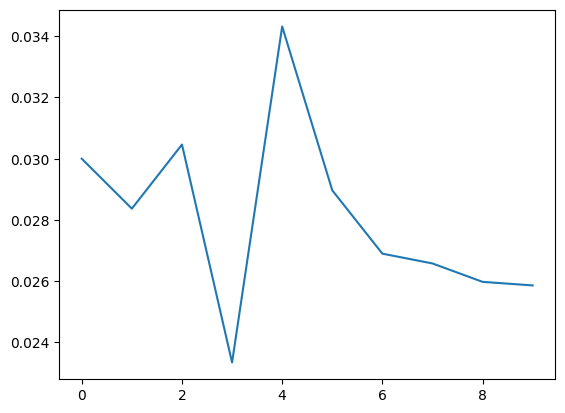

In [25]:
trainloader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)

train_loop(model, trainloader, criterion, optimizer, 10, DEVICE)

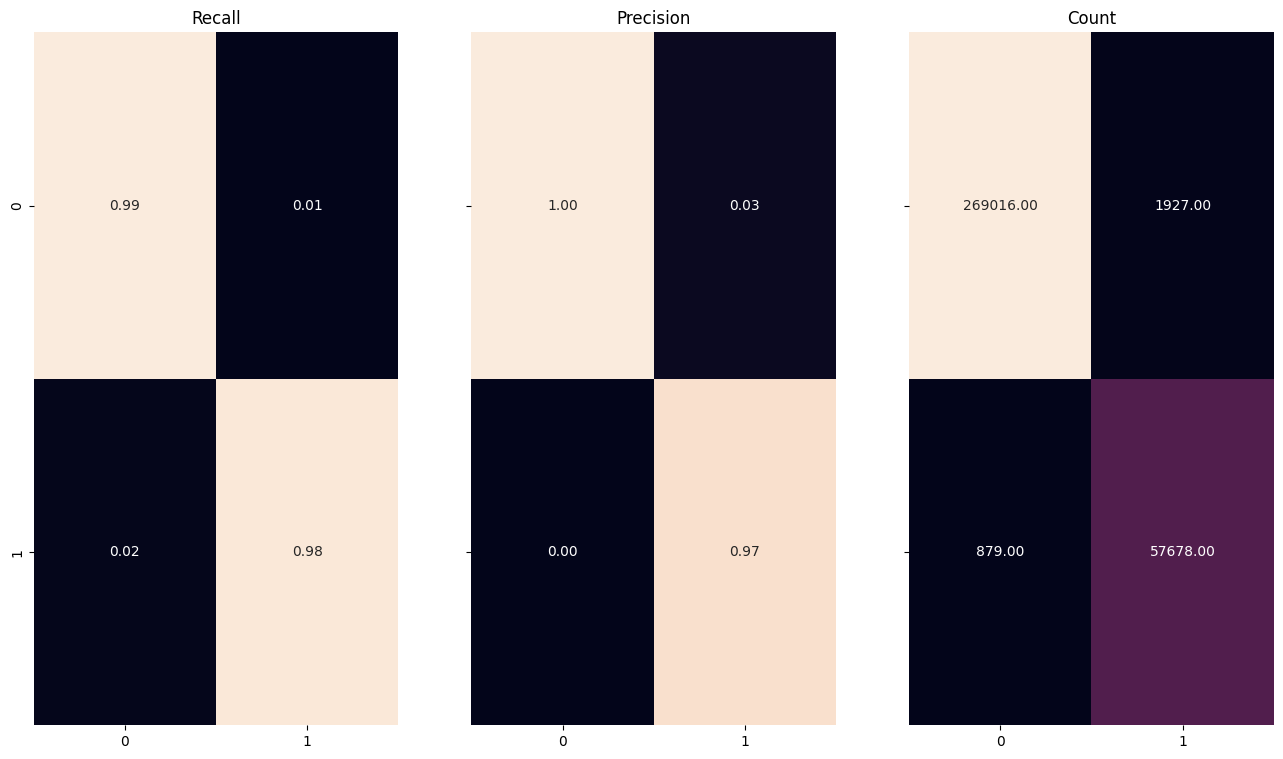

Metric         Value
---------  ---------
loss       0.0212929
precision  0.96767
recall     0.984989
f1         0.976253


In [26]:
metrics = evaluate_loop(model, criterion, trainloader, DEVICE, metrics=True)
plot_and_save_cm(metrics['true'], metrics['pred'])
summary(metrics)

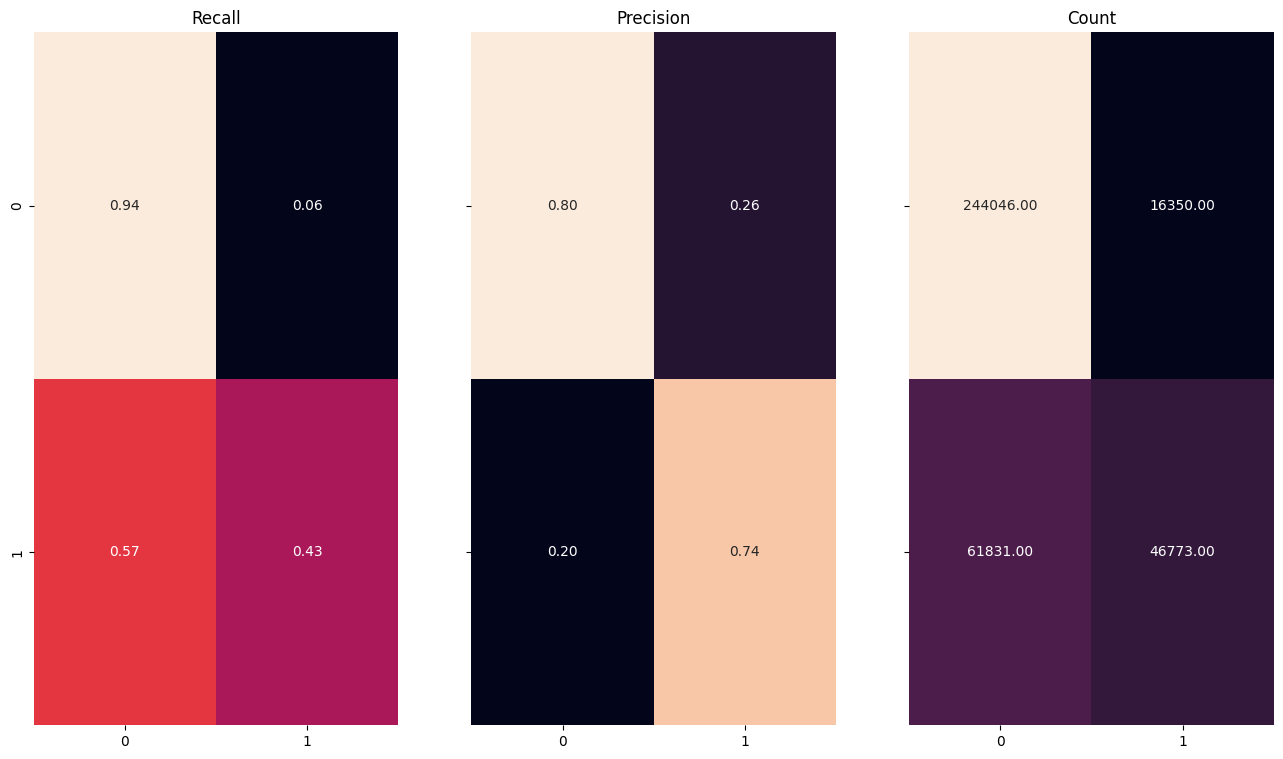

Metric        Value
---------  --------
loss       2.26035
precision  0.740982
recall     0.430675
f1         0.544737


In [27]:
testloader = DataLoader(TensorDataset(Xte,yte), batch_size=64)

metrics = evaluate_loop(model, criterion, testloader, DEVICE, metrics=True)
plot_and_save_cm(metrics['true'], metrics['pred'])
summary(metrics)

In [29]:
test_session = test_sessions[1]

test_to_plot = read_session(test_session, raw_dir)
Xtest, ytest = read_and_window_session(test_session, WINSIZE, raw_dir, label_dir)
metrics = evaluate_loop(
    model, 
    criterion, 
    DataLoader(TensorDataset(Xtest, ytest), batch_size=64), 
    DEVICE, 
    metrics=True
)
summary(metrics)

test_to_plot['y_true'] = metrics['true']
test_to_plot['y_pred'] = metrics['pred'] * 2

fig = px.line(test_to_plot[::5], x=test_to_plot.index[::5], y=['x_acc','y_acc','z_acc', 'y_true', 'y_pred'])
fig.show(renderer='browser')

Metric        Value
---------  --------
loss       3.64557
precision  0.753267
recall     0.470386
f1         0.579128
Opening in existing browser session.


Gtk-Message: 13:04:37.726: Failed to load module "xapp-gtk3-module"
Gtk-Message: 13:04:37.726: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
Gtk-Message: 13:04:37.727: Failed to load module "appmenu-gtk-module"

(brave:8807): Gtk-WARNING **: 13:04:37.808: GTK+ module /snap/brave/295/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 13:04:37.808: Failed to load module "canberra-gtk-module"

(brave:8807): Gtk-WARNING **: 13:04:37.809: GTK+ module /snap/brave/295/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 13:04:37.809: Failed to load module "canberra-gtk-module"
